# Imports

In [1]:
import sys
sys.path.append('/home/beav3r/.local/lib/python3.10/site-packages')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

print(np.__version__)

import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

# from nltk.tokenize import word_tokenize
# nltk.download('punkt_tab')

from nltk.stem import PorterStemmer

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

2.0.1


[nltk_data] Downloading package stopwords to /home/beav3r/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/beav3r/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data

In [3]:
train = pd.read_csv('final_project_train_dataset/train.csv')
train.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


In [4]:
"""No way, there are no missing values in the dataset. This is a good sign. Let's check the distribution of the target variable."""
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [5]:
# Setting target variable
target_train = train.sentiment

In [6]:
"""Wow, there are even no need to visualize it :)"""
# Checking the distribution of the target variable
target_train.value_counts() / target_train.shape[0] * 100

sentiment
positive    50.0
negative    50.0
Name: count, dtype: float64

# EDA

In [7]:
# Collect stats from the dataset. Manually, beacuse scripts.utils is not working :(
text_stats = pd.DataFrame()
text_stats['n_words'] = train['review'].apply(lambda x: len(str(x).split()))
text_stats['length'] = train['review'].apply(lambda x: len(str(x)))
text_stats['n_numbers'] = train['review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
text_stats['numbers_ratio'] = text_stats['n_numbers'] / text_stats['n_words']
text_stats['avg_word_length'] = train['review'].apply(lambda x: np.mean([len(word) for word in x.split()]))
text_stats['n_letters'] = train['review'].apply(lambda x: len([x for x in x.split() if x.isalpha()]))
text_stats['n_upper'] = train['review'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
text_stats['uppers_ratio'] = text_stats['n_upper'] / text_stats['n_words']
text_stats.head()

,n_words,length,n_numbers,numbers_ratio,avg_word_length,n_letters,n_upper,uppers_ratio
0,161,892,1,0.006211,4.546584,130,6,0.037267
1,170,937,0,0.000000,4.517647,147,6,0.035294
2,69,468,0,0.000000,5.797101,53,0,0.000000
3,314,1960,2,0.006369,5.245223,235,1,0.003185
4,183,1015,0,0.000000,4.551913,149,6,0.032787


In [8]:
"""There are little amount of numbers in the text. Considering this fact, we can clean them.
Also, during cleaning, we can ramove capitals and punctuation marks.
Let's do it, after visualizing the stats."""
text_stats.describe()

,n_words,length,n_numbers,numbers_ratio,avg_word_length,n_letters,n_upper,uppers_ratio
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,231.362750,1310.549450,0.568725,0.002688,4.640649,191.669775,4.878525,0.023486
std,171.083908,987.955229,1.110049,0.005403,0.341662,142.501504,5.584895,0.022541
min,4.000000,41.000000,0.000000,0.000000,1.239865,1.000000,0.000000,0.000000
25%,126.000000,699.000000,0.000000,0.000000,4.417539,105.000000,1.000000,0.008065
50%,173.000000,971.000000,0.000000,0.000000,4.627206,145.000000,3.000000,0.018072
75%,282.000000,1595.000000,1.000000,0.003861,4.847458,232.000000,6.000000,0.033058
max,2470.000000,13704.000000,33.000000,0.131148,12.290909,2155.000000,151.000000,1.000000


In [9]:
# changing target positive to 1 and negative to 0
target_train = target_train.map({'positive': 1, 'negative': 0})

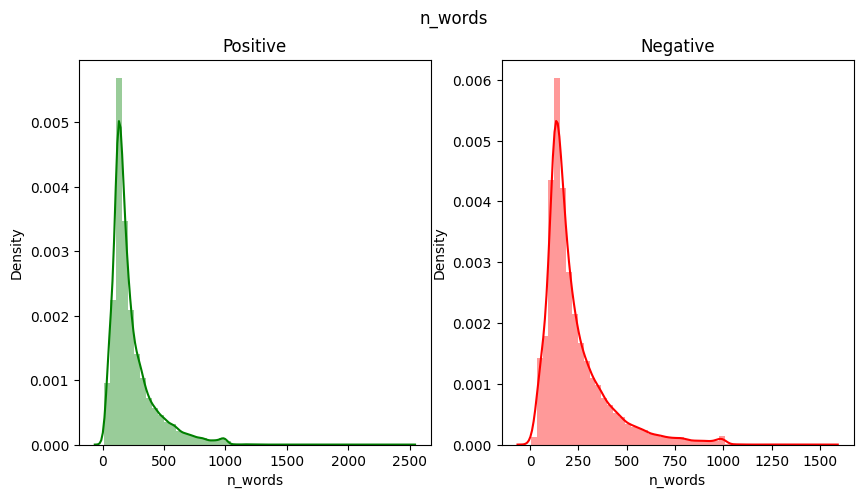

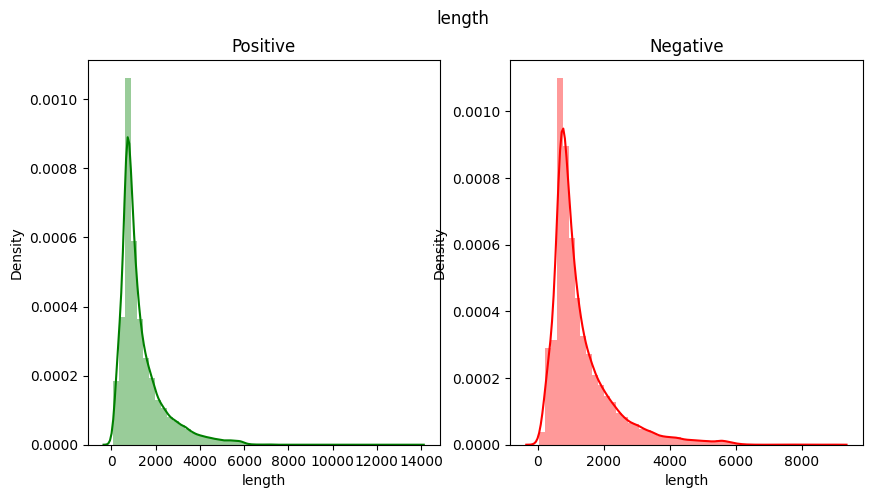

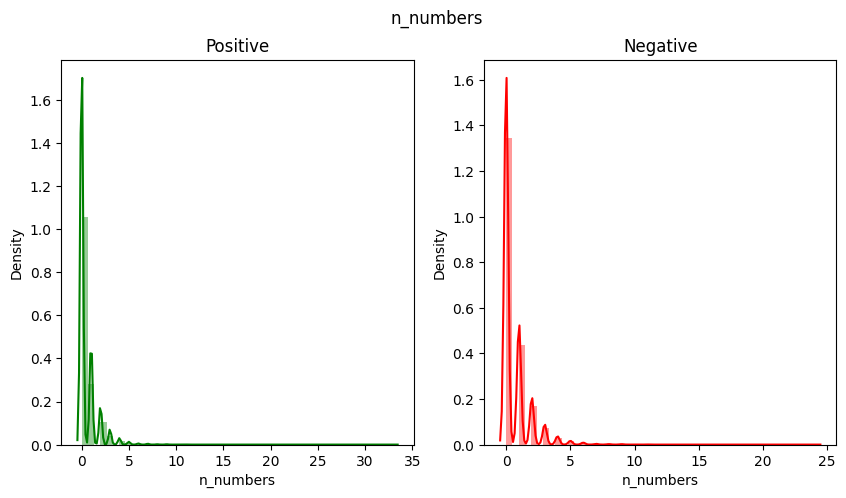

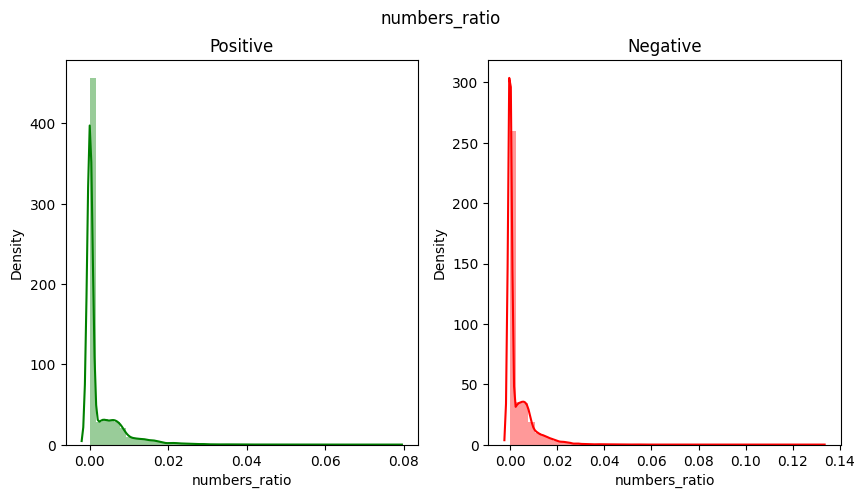

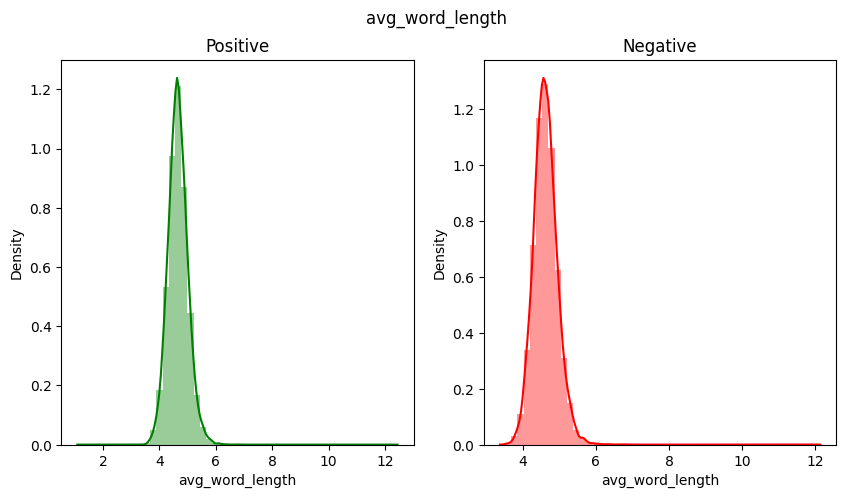

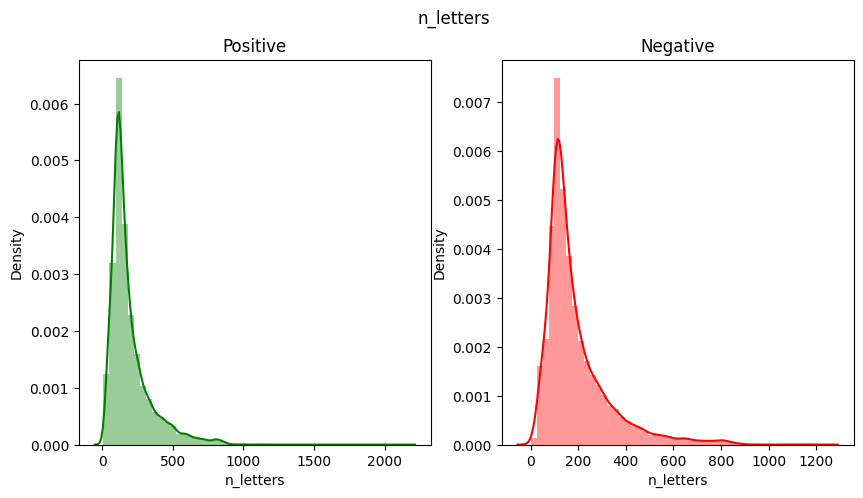

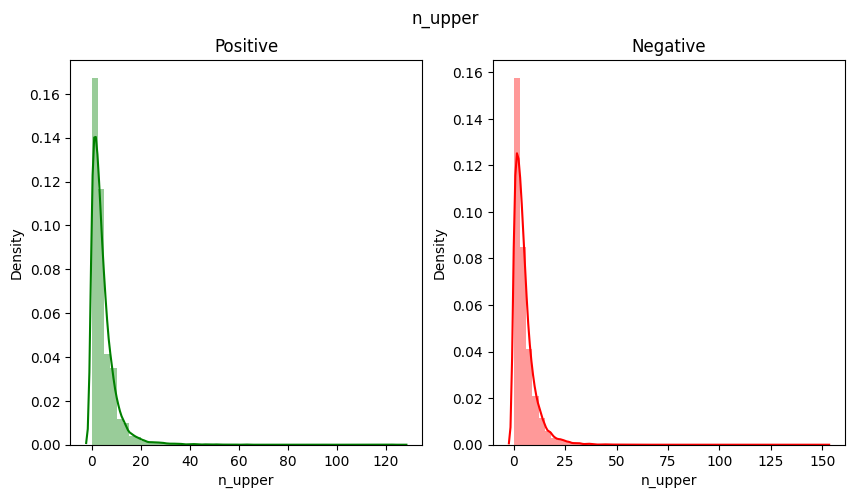

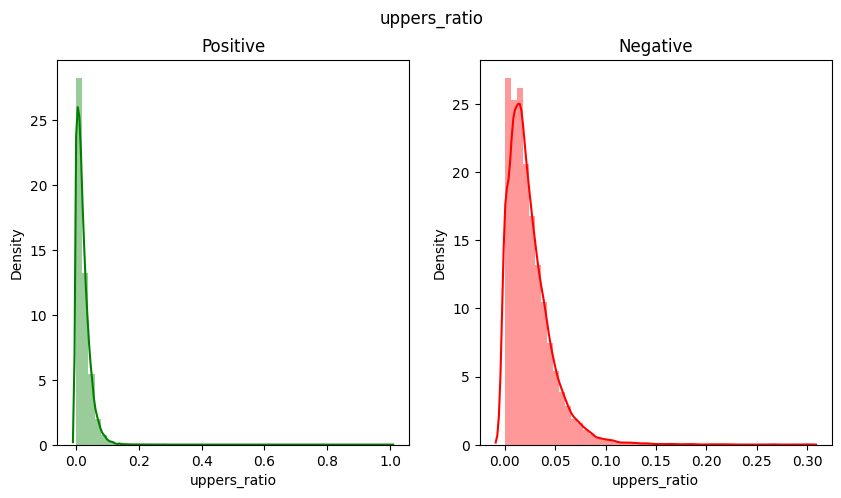

In [10]:
"""As expected, we can not see any difference between positive and negative reviews only by looking at the stats."""
# Visualizing the stats
for stat in text_stats.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    sns.distplot(text_stats[target_train == 1][stat], ax=ax1, color='green')
    ax1.set_title('Positive')
    sns.distplot(text_stats[target_train == 0][stat], ax=ax2, color='red')
    ax2.set_title('Negative')
    fig.suptitle(stat)

# Cleaning and Tokenizing

In [11]:
# Cleaning and tokenizing the text
def clean__and_tokenize_text(text, cachedStopWords=cachedStopWords):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [12]:
cleaned_and_tokenized_text_train = train['review'].apply(lambda x: clean__and_tokenize_text(x))

cleaned_and_tokenized_text_train.head()

0    caught little gem totally accident back   revi...
1    cant believe let movie accomplish favor friend...
2    spoiler alert gets nerve people remake and use...
3    theres one thing ive learnt watching george ro...
4    remember theaters reviews said horrible well t...
Name: review, dtype: object

# Normalisation

In [13]:
# Stemming the text
stemmer = PorterStemmer()

stemmed_text_train = cleaned_and_tokenized_text_train.apply(lambda x: ''.join([stemmer.stem(word) for word in x]))

stemmed_text_train.head()

0    caught little gem totally accident back   revi...
1    cant believe let movie accomplish favor friend...
2    spoiler alert gets nerve people remake and use...
3    theres one thing ive learnt watching george ro...
4    remember theaters reviews said horrible well t...
Name: review, dtype: object

In [14]:
# Lemmatizing the text

lemmatizer = WordNetLemmatizer()

lemmatized_text_train = cleaned_and_tokenized_text_train.apply(lambda x: ''.join([lemmatizer.lemmatize(word) for word in x]))

lemmatized_text_train.head()

0    caught little gem totally accident back   revi...
1    cant believe let movie accomplish favor friend...
2    spoiler alert gets nerve people remake and use...
3    theres one thing ive learnt watching george ro...
4    remember theaters reviews said horrible well t...
Name: review, dtype: object

# Baseline + LogReg

In [15]:
# Prepearing test data

test = pd.read_csv('final_project_test_dataset/test.csv')

target_test = test.sentiment.map({'positive': 1, 'negative': 0})

cleaned_and_tokenized_text_test = test['review'].apply(lambda x: clean__and_tokenize_text(x))

stemmed_text_test = cleaned_and_tokenized_text_test.apply(lambda x: ''.join([stemmer.stem(word) for word in x]))

lemmatized_text_test = cleaned_and_tokenized_text_test.apply(lambda x: ''.join([lemmatizer.lemmatize(word) for word in x]))

In [16]:
def model_baseline(clf, X_train_stem, X_train_lem, y_train, X_test_stem, X_test_lem, y_test, parameters):
   
    pipeline = Pipeline([('vectorizer', CountVectorizer()), 
                        ('clf', clf)])

    grid_search_stemmed = GridSearchCV(pipeline, parameters, cv=StratifiedKFold(n_splits=5), scoring='f1', verbose=2)

    grid_search_stemmed.fit(X_train_stem, y_train)

    grid_search_lemmatized = GridSearchCV(pipeline, parameters, cv=StratifiedKFold(n_splits=5), scoring='f1', verbose=2)

    grid_search_lemmatized.fit(X_train_lem, y_train)

    y_pred_stemmed = grid_search_stemmed.predict(X_test_stem)
    y_pred_lemmatized = grid_search_lemmatized.predict(X_test_lem)

    print('Stemmed text:')
    print(classification_report(y_test, y_pred_stemmed))
    print('Lemmatized text:')
    print(classification_report(y_test, y_pred_lemmatized))

    # Words importance from pipeline with best parameters

    best_params_stemmed = grid_search_stemmed.best_params_
    best_params_lemmatized = grid_search_lemmatized.best_params_

    pipeline.set_params(**best_params_stemmed)
    pipeline.fit(X_train_stem, y_train)

    words_importance_stemmed = pipeline.named_steps['clf'].coef_[0]
    words_importance_stemmed = pd.Series(words_importance_stemmed, index=pipeline.named_steps['vectorizer'].get_feature_names_out())

    pipeline.set_params(**best_params_lemmatized)
    pipeline.fit(X_train_lem, y_train)

    words_importance_lemmatized = pipeline.named_steps['clf'].coef_[0]
    words_importance_lemmatized = pd.Series(words_importance_lemmatized, index=pipeline.named_steps['vectorizer'].get_feature_names_out())

    # Visualizing words importance for positive and negative reviews

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    words_importance_stemmed.nlargest(10).plot(kind='barh', ax=ax1, color='green')
    words_importance_stemmed.nsmallest(10).plot(kind='barh', ax=ax2, color='red')
    ax1.set_title('Stemmed text - positive')
    ax2.set_title('Stemmed text - negative')
    words_importance_lemmatized.nlargest(10).plot(kind='barh', ax=ax3, color='green')
    words_importance_lemmatized.nsmallest(10).plot(kind='barh', ax=ax4, color='red')
    ax2.set_title('Lemmatized text - positive')
    ax2.set_title('Lemmatized text - negative')

    return



Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .......................................clf__C=0.001; total time=   6.2s
[CV] END .......................................clf__C=0.001; total time=   5.8s
[CV] END .......................................clf__C=0.001; total time=   5.4s
[CV] END .......................................clf__C=0.001; total time=   5.4s
[CV] END .......................................clf__C=0.001; total time=   5.6s
[CV] END ........................................clf__C=0.01; total time=   9.3s
[CV] END ........................................clf__C=0.01; total time=   8.0s
[CV] END ........................................clf__C=0.01; total time=   9.1s
[CV] END ........................................clf__C=0.01; total time=   9.7s
[CV] END ........................................clf__C=0.01; total time=   8.2s
[CV] END .........................................clf__C=0.1; total time=  14.7s
[CV] END ........................................

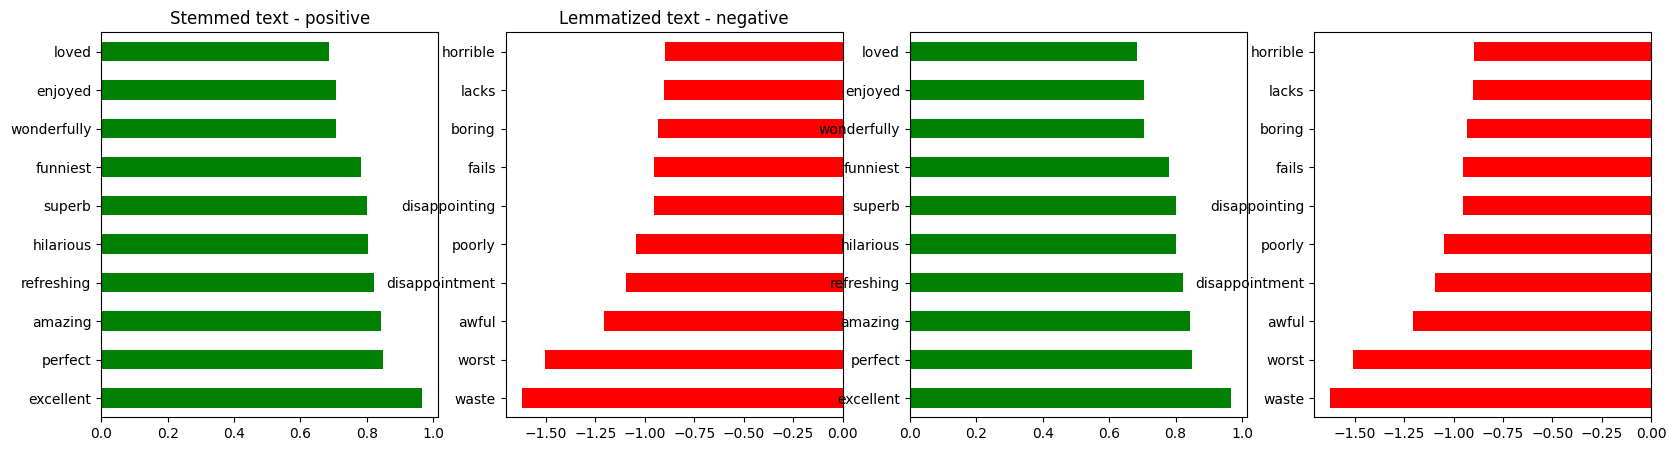

In [17]:
parameters = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf = LogisticRegression()

model_baseline(clf, stemmed_text_train, lemmatized_text_train, target_train, stemmed_text_test, lemmatized_text_test, target_test, parameters)


# SVM

In [18]:
parameters = [{'clf__kernel': ['rbf'], 'clf__gamma': [1e-3, 1e-4],
                     'clf__C': [1, 10, 100, 1000]}]

clf = SVC()

model_baseline(clf, stemmed_text_train, lemmatized_text_train, target_train, stemmed_text_test, lemmatized_text_test, target_test, parameters)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........clf__C=1, clf__gamma=0.001, clf__kernel=rbf; total time=11.5min
[CV] END ........clf__C=1, clf__gamma=0.001, clf__kernel=rbf; total time=11.5min
[CV] END ........clf__C=1, clf__gamma=0.001, clf__kernel=rbf; total time=11.4min
[CV] END ........clf__C=1, clf__gamma=0.001, clf__kernel=rbf; total time=11.4min
[CV] END ........clf__C=1, clf__gamma=0.001, clf__kernel=rbf; total time=11.6min
[CV] END .......clf__C=1, clf__gamma=0.0001, clf__kernel=rbf; total time=11.9min
[CV] END .......clf__C=1, clf__gamma=0.0001, clf__kernel=rbf; total time=11.9min
[CV] END .......clf__C=1, clf__gamma=0.0001, clf__kernel=rbf; total time=11.9min
[CV] END .......clf__C=1, clf__gamma=0.0001, clf__kernel=rbf; total time=11.9min
[CV] END .......clf__C=1, clf__gamma=0.0001, clf__kernel=rbf; total time=11.9min
[CV] END .......clf__C=10, clf__gamma=0.001, clf__kernel=rbf; total time=19.6min
[CV] END .......clf__C=10, clf__gamma=0.001, clf_

# NB

In [ ]:
parameters = [{'clf__alpha': [0, 0.5, 1.0, 5, 10], 'clf__fit_prior':[True, False]}]

clf = MultinomialNB()

model_baseline(clf, stemmed_text_train, lemmatized_text_train, target_train, stemmed_text_test, lemmatized_text_test, target_test, parameters)

# Conclusions

Theoretically SVM and LogReg should show slightly better results with lemmatizing than stemming, because lemmatizing gets words meanings when stemming just getting the roots. 
Also lemmatizing took 69sec while stemming is 9sec.
As for the NB, it doesn't depend on words meaning and shows attention more to their frequency, so it should show simmilar results
for stemming and lemmatizing.
In this experiment I got results that are described below
1) LogReg
2) SVM
3) NB
